### Importing Libraries

In [309]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Pre Processing Step

In [310]:
# Load the CSV
file_path = "data/NewsData.io_TSLA.csv"  # Adjust path if needed
df = pd.read_csv(file_path)

In [311]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

In [312]:
# Checking distinct languages and counting values
df['language'].value_counts()

language
"english"       10523
"spanish"        2748
"german"           14
"french"           13
"romanian"          7
"portuguese"        1
"italian"           1
Name: count, dtype: int64

In [313]:
# Drop rows with missing sentiment or content
df_en = df.dropna(subset=["sentiment", "content"])

# Storing only english content in new df
df_en = df_en[df_en['language'] == '"english"']

# Quick look
df_en[["pubDate", "title", "sentiment"]].head()

,pubDate,title,sentiment
0,"""2025-01-15 22:16:52""","""My Prediction for 2025 – and a Profit-Generat...","""positive"""
1,"""2025-01-15 22:00:00""","""Boeing needs 'tough love,' says Trump's trans...","""positive"""
6,"""2025-01-15 21:13:08""","""NASDAQ snaps five-day losing streak with its ...","""positive"""
7,"""2025-01-15 20:55:20""","""What's Going On With Tesla Shares Wednesday?""","""neutral"""
8,"""2025-01-15 20:42:47""","""Electric Vehicle Sales Leaders — Best Selling...","""neutral"""


In [328]:
# Text preprocessing function
def basic_preprocess(text):
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove punctuation, emojis, special characters (keep letters, numbers, space)
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    
    # Tokenize
    tokens = text.split()
    
    # Remove stopwords and non-alpha tokens
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS and word.isalpha()]
 
    # Apply lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Return cleaned string
    return " ".join(tokens)

In [329]:
#
df_en["content"].head(5)

0    "Hello, Reader. Mark Twain once remarked, “The...
1    "President-elect Donald Trump’s nominee to suc...
6    "The major stock indices cheered on the combin...
7    "Tesla, Inc . TSLA stock is trading higher on ...
8    "A closer look at the best-selling PEV automot...
Name: content, dtype: object

In [337]:
# Apply to content
df_en["tokens"] = df_en["content"].apply(basic_preprocess)
df_en["text_ready"] = df_en["tokens"].apply(lambda x: "".join(x))

In [338]:
df_en["tokens"].head(5)

0    hello reader mark twain remarked art prophecy ...
1    president elect donald trump s nominee succeed...
6    major stock index cheered combined ppi cpi dat...
7    tesla tsla stock trading higher wednesday amid...
8    closer look best selling pev automotive group ...
Name: tokens, dtype: object

In [339]:
# Encode sentiment
le = LabelEncoder()
df_en["sentiment_encoded"] = le.fit_transform(df_en["sentiment"].str.strip('"'))

In [340]:
df_en["text_ready"].head()

0    hello reader mark twain remarked art prophecy ...
1    president elect donald trump s nominee succeed...
6    major stock index cheered combined ppi cpi dat...
7    tesla tsla stock trading higher wednesday amid...
8    closer look best selling pev automotive group ...
Name: text_ready, dtype: object

In [341]:
df_en["sentiment_encoded"].head()

0    2
1    2
6    2
7    1
8    1
Name: sentiment_encoded, dtype: int64

In [342]:
# TF-IDF Vectorization
# Initialize vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # you can adjust max_features

# Fit-transform your text column
X = tfidf.fit_transform(df_en["text_ready"])

# Your target variable
y = df_en["sentiment_encoded"]

### Training and Testing

In [343]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Train Model

In [344]:
# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### Evaluate

              precision    recall  f1-score   support

    negative       0.60      0.42      0.49       463
     neutral       0.66      0.85      0.74      1116
    positive       0.51      0.24      0.32       323

    accuracy                           0.64      1902
   macro avg       0.59      0.50      0.52      1902
weighted avg       0.62      0.64      0.61      1902



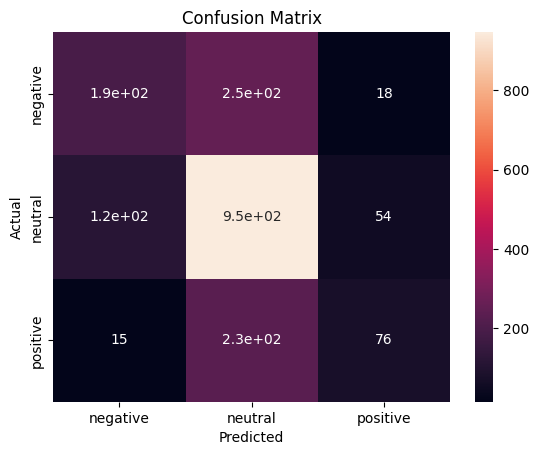

In [346]:
# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()